In [3]:
library(repr) ; options(repr.plot.width = 5, repr.plot.height = 6) # Change plot sizes (in cm)

# Model Fitting the Bayesian Way

## Introduction


In this Chapter we will work through various examples of  model fitting  to biological data using Bayesian Methods. It is recommended that you see the [lecture](https://github.com/mhasoba/TheMulQuaBio/tree/master/content/lectures/ModelFitting) on model fitting in Ecology and Evolution. 

Recall from the [lectures](https://github.com/vectorbite/VBiTraining2/tree/master/lectures) that for Bayesian model fitting/inference, we need to: 


1. **Assess MCMC convergence**: MCMC is family of algorithm for sampling probability distributions so that it can be adequately characterized (in the Bayesian context the posterior distribution). The MCMC procedure reaches * convergence * once we have sufficient random draws from the posterior distribution. To assess convergence we look at trace plots. The goal is to get "fuzzy caterpillars"-looking curves. 

2. **Summarize MCMC draws**: Summarize and visualize outcome of the random draws using histograms for all draws for each parameter, and calculate expectation, variance, credibility interval, etc.

3. **Prior Sensitivity**: Assess prior sensitivity by changing prior values and check whether it affects the results or not. If it does, that means that the results are too sensitive to that prior, not good!

4. **Make inferences**: We use the values from item (2) to make inferences and answer the research question.

Because likelihoods form the basis for Bayesian model fitting, we will first do an exercise to understand their calculation. 

We will use R. For starters, clear all variables and graphic devices and load necessary packages:

In [4]:
rm(list = ls())
graphics.off()

## A Likelihoods exercise

### The Binomial Distribution

The Binomial distribution is used to model the number of "successes" in a set of trials (e.g., number of heads when you flip a coin $N$ times). The pmf is 

$$
{N \choose x} p^x(1-p)^{N-x}
$$

such that $\mathrm{E}[x] = Np $. Throughout this "experiment", you will assume that your experiment consists of flipping 20 coins, so that $N = 20$.

Let's use the Binomial distribution to practice two methods of estimating parameters for a probability distribution: method of moments and maximum likelihood.

#### Simulating from the Binomial using R

First take 50 draws from a binomial (using _rbinom_) for each $p\in$ 0.1, 0.5, 0.8 with $N=20$. For this, lets set seed so that we can reproduce this exact sequence of sampling (why?):

In [5]:
set.seed(54321)

In [6]:
## 50 draws with each p 
pp <- c(0.1, 0.5, 0.8)
N <- 20
reps <- 50 

Now plot the histograms of these draws together with the density functions.

In [7]:
## histograms + density here
x <- seq(0, 50, by=1)
par(mfrow=c(1,3), bty="n")

# Write more code here

**Q1: Do the histograms look like the distributions for all 3 values of $p$? If not, what do you think is going on?** 

You'll notice that for $p=0.1$ the histogram and densities don't look quite the same -- the `hist()` function is lumping together the zeros and ones which makes it look off. This is typical for distributions that are truncated.

### Method of Moments (MoM) Estimators

To obtain a method of moments estimator, we equate the theoretical moments (which will be a function of the parameters of the distribution) with the corresponding sample moments, and solve for the parameters in order to obtain an estimate. For the binomial distribution, there is only one parameter, $p$. 

**Q2: Given the analytic expected value, above, and assuming that the sample mean is $m$ (the mean number of observed heads across replicates), what is the MoM estimator for $p$?** 

Now calculate the MoM estimator for each of your 3 sets of simulated data sets to get the estimates for each of your values of $p$.

In [8]:
## MOM estimators for 3 simulated sets


 **Q3: How good are your estimates for $p$? Do you get something close to the true value?** 

For 1 of your values of $p$, take 20 draws from the binomial with $N=20$ and calculate the MoM. Repeat this 100 times (hint: the `replicate()` and `lapply` functions may be useful.) Make a histogram of your estimates, and add a line/point to the plot to indicate the real value of $p$ that you used to simulate the data. 

In [9]:
## MoM estimates, histogram 

 **Q4: Is the MoM successfully estimating $p$? Does your histogram for $p$ look more or less normal? If so, what theorem might explain why this would be the case?** 

### MLE for Binomial Distribution

#### Likelihood and Log Likelihood

Imagine that you flip a coin $N$ times, and then repeat the experiment $n$ times. Thus, you have data $x=x`1, x`2, \dots x`n$ that are the number of times you observed a head in each trial. $p$ is the probability of obtaining a head. 

**Q5: Write down the likelihood and log-likelihood for the data. Take the derivative of the negative log-likelihood, set this equal to zero, and find the MLE, $\hat{p}$.**

### Computing the likelihood and MLE in R

Simulate some data with $p=0.25$, $N=10$, and 10 replicates. Calculate the negative log-likelihood of your simulated data across a range of $p$ (from 0 to 1), and plot them. You may do this by using the built in functions in R (specifically `dbinom`) or write your own function. This is called a "likelihood profile''. Plot your likelihood profile with a line indicating the true value of $p$. Add lines indicating the MLE $\hat{p}$ and the MoM estimator for $p$ to your likelihood profile. 

In [10]:
pp <- .25
N <- 10
reps <- 10
## Make one set of data

## the likelihood is always exactly zero
## at p=0,1, so I skip those values
ps <- seq(0.01, 0.99, by=0.01) 

## Likelihood


## MLE/MoM estimators 

## now plot the negative log likelihood profile


**Q6: How does your MLE compare to the true parameter value? How could you estimate the MLE from the likelihood profile if you didn't have a way to calculate the MLE directly? If you chose another version of the random seed, do you get the same answer?**

## Example: Midge Wing Length

We will use this simple example to go through the steps of assessing a Bayesian model and we'll see that MCMC can allow us to approximate the posterior distribution.

Grogan and Wirth (1981) provide data on the wing length (in millimeters) of nine members of a species of midge (small, two-winged flies). 

From these measurements we wish to make inference about the population mean $\mu$.

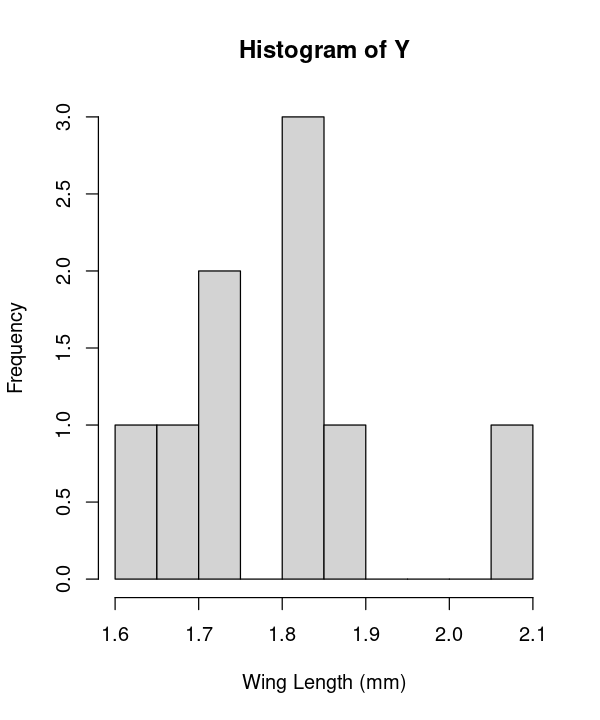

In [11]:
WL.data <- read.csv("../data/MidgeWingLength.csv")
Y <- WL.data$WingLength
n <- length(Y)

hist(Y,breaks=10,xlab="Wing Length (mm)") 

### Non-Bayesian analysis

We might expect that these midge data could be draws from a _Normal_ distribution $\mathcal{N}(\mu, \sigma^2)$. [Recall](./21-ModelFitting-MLE.ipynb) that the MLEs for $\mu$ and $\sigma^2$ here are simply the *sample mean* and *sample variance* respectively:

In [12]:
m <- sum(Y)/n
s2 <- sum((Y-m)^2)/(n-1)
round(c(m, s2), 3)

[1] 1.804 0.017

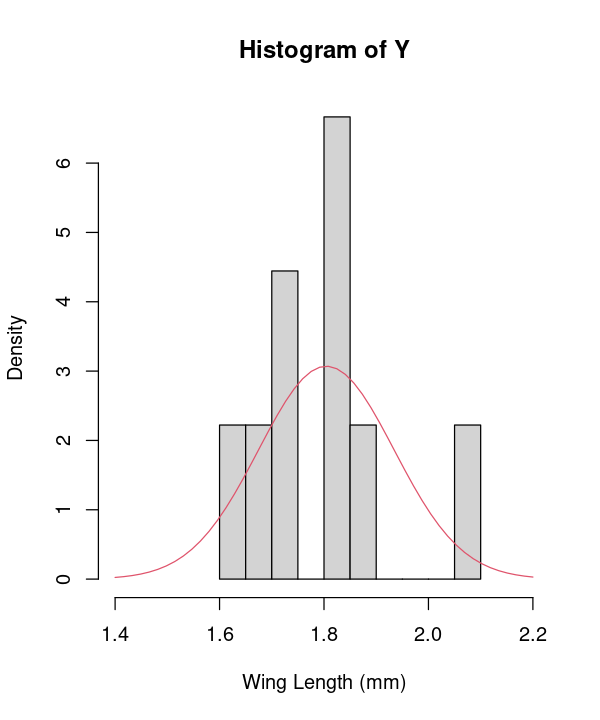

In [13]:
x <- seq(1.4,2.2, length=50)
hist(Y,breaks=10,xlab="Wing Length (mm)", xlim=c(1.4, 2.2), freq=FALSE) 
lines(x, dnorm(x, mean=m, sd=sqrt(s2)), col=2)

```{note} 

We have plotted the estimate of the _population_ distribution here, but this is not the *predictive distribution* (which would be a Student's $t$ because we're estimating both the mean and variance.)
```

The non-Bayesian version here has the advantage of being quick and familiar. However, from our point of view it has two weaknesses:

1. Because we have so few data points estimates of the accuracy of our predictions aren't available. 9 points is only barely enough to estimate a mean, so we don't trust any of the variance calculations.

2. We can't easily incorporate things that we might already know about midges into our analysis. 

Let's see how we can do a similar analysis using a Bayesian approach, first analytically, and the with JAGS.

### Setting up the Bayesian Model

We need to define the likelihood and the priors for our Bayesian analysis. Given the analysis that we've just done, let's assume that our data come from a normal distribution with unknown mean, $\mu$ but that we know the variance is $\sigma^2 = 0.025$. That is:

$$
\mathbf{Y} \stackrel{\mathrm{iid}}{\sim} \mathcal{N}(\mu, 0.025^2)
$$


#### Prior Information

Studies from other populations suggest that wing lengths are usually around 1.9 mm, so we set $\mu_0 = 1.9$

We also know that lengths must be positive ($\mu >0$)

We can approximate this restriction with a normal prior distribution for $\mu$ as follows:

Since most of the normal density is within two standard deviations of the mean we choose $\tau^2_0$ so that

$$ \mu_0 - 2\sigma_0 >0 \Rightarrow \sigma_0 <1.9/2 = 0.95 $$
I will choose $\sigma_0=0.8$ here. Thus our prior for mu will be:
$$
\mu \sim \mathcal{N}(1.9, 0.8^2)
$$

----

Together, then, our full model is:

\begin{align*}
    \mathbf{Y} & \stackrel{\mathrm{iid}}{\sim} \mathcal{N}(\mu, 0.025^2)\\
    \mu &\sim \mathcal{N}(1.9, 0.8^2)
\end{align*}

### Analytic Posterior

For this very simple case it is easy to write down the posterior distribution (up to some constant). First, note that the likelihood for the data can be written as 

\begin{align*}
    \mathcal{L} &\propto \prod_{i=1}^n \frac{1}{\sigma} \exp\left(-\frac{1}{2\sigma^2}(Y_i-\mu)^2 \right) \\
    & = \frac{1}{\sigma^n} \exp\left(-\frac{1}{2\sigma^2}\sum_{i=1}^n (Y_i-\mu)^2 \right)\\
    & \propto \exp\left(-\frac{n}{2\sigma^2} (\bar{Y}-\mu)^2 \right)
\end{align*}

Multiplying the prior through we get the following for the posterior:

$$
\mathrm{P}(\mu|\mathbf{Y}) \propto \exp \left(-\frac{n}{2\sigma^2} (\bar{Y}-\mu)^2 \right) \exp\left(-\frac{1}{2\sigma_0^2}(\mu-\mu_0)^2 \right)
$$

You can re-arrange, complete the square, etc, to get a new expression that is like

$$
\mathrm{P}(\mu|\mathbf{Y}) \propto \exp \left(-\frac{1}{2\sigma_p^2} (\mu_p-\mu)^2 \right)
$$

where 

\begin{align*}
\mu_p & = \frac{n\sigma_0^2}{\sigma^2 + n\sigma_0^2} \bar{Y} + \frac{\sigma^2}{\frac{\sigma^2}{n} + \sigma_0^2} \mu_0\\
& \\
\sigma_p^2 & = \left( \frac{n}{\sigma^2} + \frac{1}{\sigma_0^2} \right)^{-1}
\end{align*}

Instead of writing this last in terms of the variances, we could instead use precision (the inverse variance) which gives a simpler expression:

$$
\tau_p = n\tau + \tau_0
$$

Just like in our earlier example, our estimate of the mean is a weighted average of the data and the prior, with the variance being determined by the data and prior variances.

So lets write a little function to calculate $\mu_p$ and $\tau_p$ and the plug in our numbers:

In [14]:
tau.post <- function(tau, tau0, n){n * tau + tau0}
mu.post <- function(Ybar, mu0, sig20, sig2, n){
 weight <- sig2+n * sig20
 
 return(n * sig20 * Ybar/weight + sig2 * mu0/weight)
}

Let's plot 3 things together -- the data histogram, the prior, and the posterior:

In [15]:
mu0 <- 1.9
s20 <- 0.8
s2 <- 0.025 ## "true" variance

mp <- mu.post(Ybar=m, mu0=mu0, sig20=s20, sig2=s2, n=n)
tp <- tau.post(tau=1/s2, tau0=1/s20, n=n)

Let's plot the result:

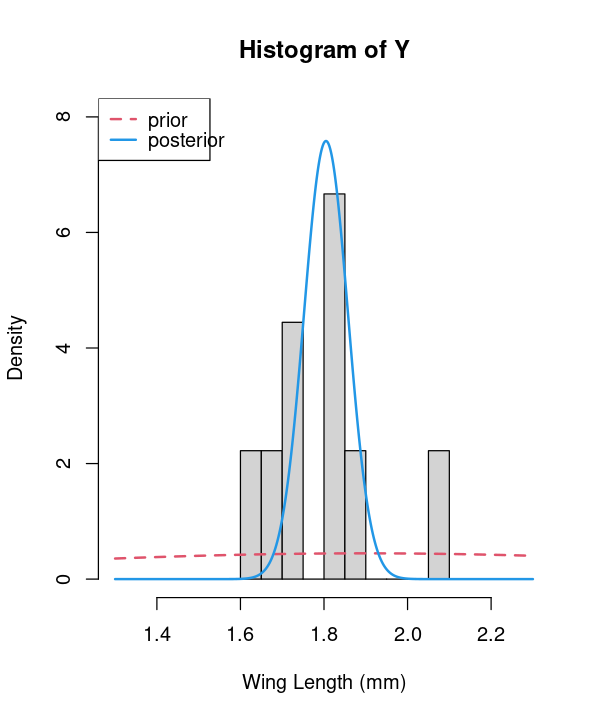

In [16]:
x <- seq(1.3,2.3, length=1000)
hist(Y,breaks=10,xlab="Wing Length (mm)", xlim=c(1.3, 2.3),
  freq=FALSE, ylim=c(0,8)) 
lines(x, dnorm(x, mean=mu0, sd=sqrt(s20)), col=2, lty=2, lwd=2) ## prior
lines(x, dnorm(x, mean=mp, sd=sqrt(1/tp)), col=4, lwd=2) ## posterior
legend("topleft", legend=c("prior", "posterior"), col=c(2,4), lty=c(2,1), lwd=2)

### Exercise: Prior sensitivity

Change the values of the mean and the variance that you choose for the prior ("hyperparameters"). What does this do to the posterior distribution. E.g., what happens if the variance you choose is small, and $\mu_0 =2.5$ or so. Is this what you expect?


### Numerical evaluation of the posterior with JAGS

Let's show that we can get the same thing from JAGS that we were able to get from the analytic results. You'll need to make sure you have installed JAGS (which must be done outside of R) and then the libraries `rjags` and `coda`.

In [17]:
# Load libraries
require(rjags) # does the fitting
require(coda) # makes diagnostic plots
##require(mcmcplots) # another option for diagnostic plots

#### Specifying the model

First we must encode our choices for our data model and priors to pass them to the fitting routines in JAGS. This involves setting up a ${\tt model}$ that includes the likelihood for each data point and a prior for every parameter we want to estimate. Here is an example of how we would do this for the simple model we fit for the midge data (note that JAGS uses the precision instead of the variance or sd for the normal distribution:

In [18]:
model1 <- "model{

 ## Likelihood
 for(i in 1:n){
 Y[i] ~ dnorm(mu,tau)
 }

 ## Prior for mu
 mu  ~ dnorm(mu0,tau0)

} ## close model 
"

Now create the JAGS model:

In [19]:
model <- jags.model(textConnection(model1), 
     n.chains = 1, ## usually do more
     data = list(Y=Y,n=n, ## data
        mu0=mu0, tau0=1/s20, ## hyperparams
        tau = 1/s2 ## known precision
        ),
     inits=list(mu=3) ## setting an starting val
     )

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 9
   Unobserved stochastic nodes: 1
   Total graph size: 14

Initializing model



Now we'll run the MCMC and, see how the output looks for a short chain with no burnin:

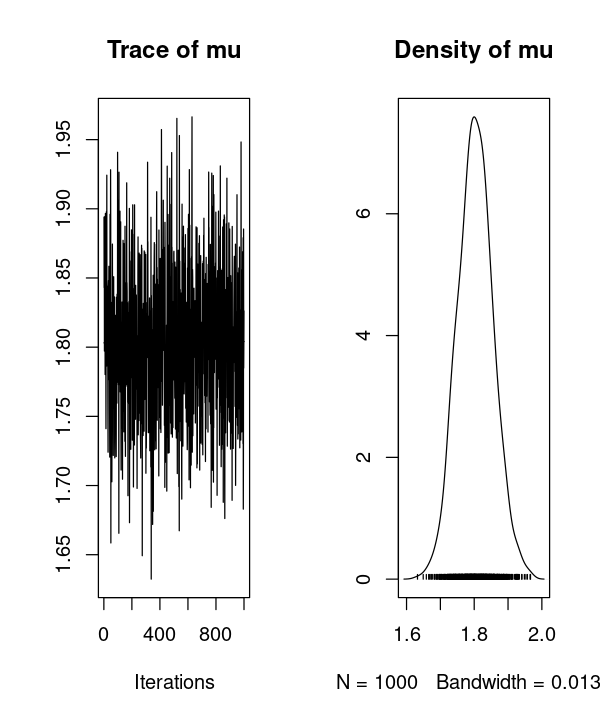

In [20]:
samp <- coda.samples(model, 
  variable.names=c("mu"), 
  n.iter=1000, progress.bar="none")

plot(samp)

MCMC is a rejection algorithm that often needs to converge or "burn-in" -- that is we need to potentially move until we're taking draws from the correct distribution. Unlike for optimization problems, this does not mean that the algorithm :eads toward a single value. Instead we're looking for a pattern where the draws are seemingly unrelated and random. To assess convergence we look at trace plots, the goal is to get traces that look like "fuzzy caterpillars". 

Sometimes at the beginning of a run, if we start far from the area near the posterior mean of the parameter, we will instead get something that looks like a trending time series. If this is the case we have to drop the samples that were taken during the burn-in phase. Here's an example of how to do that:

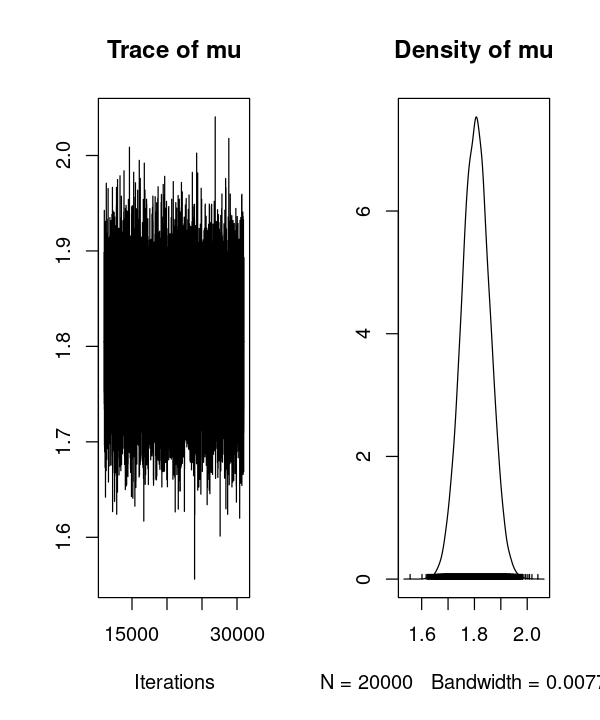

In [21]:
update(model, 10000, progress.bar="none") # Burnin for 10000 samples

samp <- coda.samples(model, 
  variable.names=c("mu"), 
  n.iter=20000, progress.bar="none")

plot(samp)

This is a very fuzzy caterpillar!

We can also use the summary function to examine the samples generated:

In [22]:
summary(samp)


Iterations = 11001:31000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 20000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
      1.804998       0.052754       0.000373       0.000373 

2. Quantiles for each variable:

 2.5%   25%   50%   75% 97.5% 
1.702 1.769 1.805 1.840 1.908 


Let's compare these draws to what we got with our analytic solution:

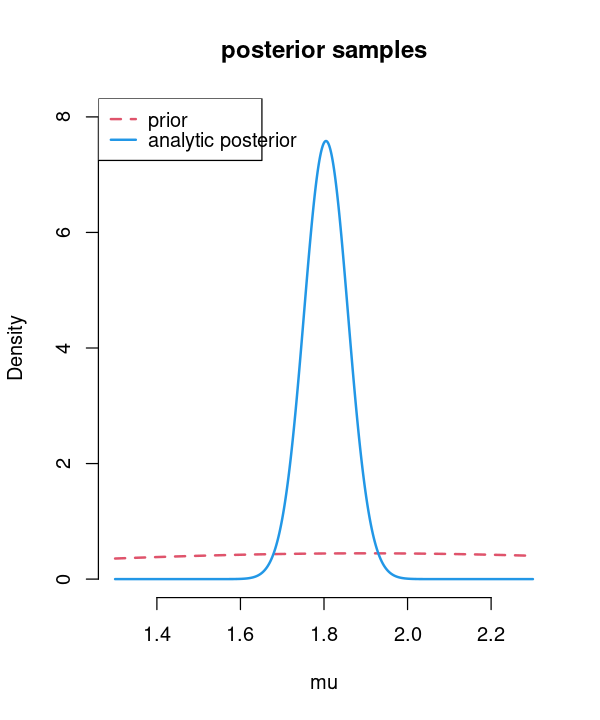

In [127]:
x <- seq(1.3,2.3, length=1000)
hist(samp[[1]], xlab="mu", xlim=c(1.3, 2.3),
  freq=FALSE, ylim=c(0,8), main ="posterior samples") 
lines(x, dnorm(x, mean=mu0, sd=sqrt(s20)), col=2, lty=2, lwd=2) ## prior
lines(x, dnorm(x, mean=mp, sd=sqrt(1/tp)), col=4, lwd=2) ## posterior
legend("topleft", legend=c("prior", "analytic posterior"), col=c(2,4), lty=c(2,1), lwd=2)

It worked! 


As with the analytic approach, it's always a good idea when you run your analyses to see how sensitive is your result to the priors you choose. Unless you are purposefully choosing an informative prior, we usually want the prior and posterior to look different.


### Estimating the population variance
 
One advantage of the numerical approach is that we can choose almost anything we want for the priors on multiple parameters without worrying if they are conjugate, or if we want to include additional information. For example, let's say that, not, we want to force the mean to be positive (and also the data, perhaps), and concurrently estimate the variance. Here is a possible model.

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 9
   Unobserved stochastic nodes: 2
   Total graph size: 740

Initializing model




Iterations = 1001:2000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean      SD  Naive SE Time-series SE
mu 0.06889 0.10389 0.0032853       0.016476
s2 0.01029 0.01799 0.0005689       0.002442

2. Quantiles for each variable:

        2.5%      25%      50%     75%  97.5%
mu -0.288547 0.071837 0.103609 0.11822 0.1525
s2  0.001188 0.002328 0.003969 0.01011 0.0590


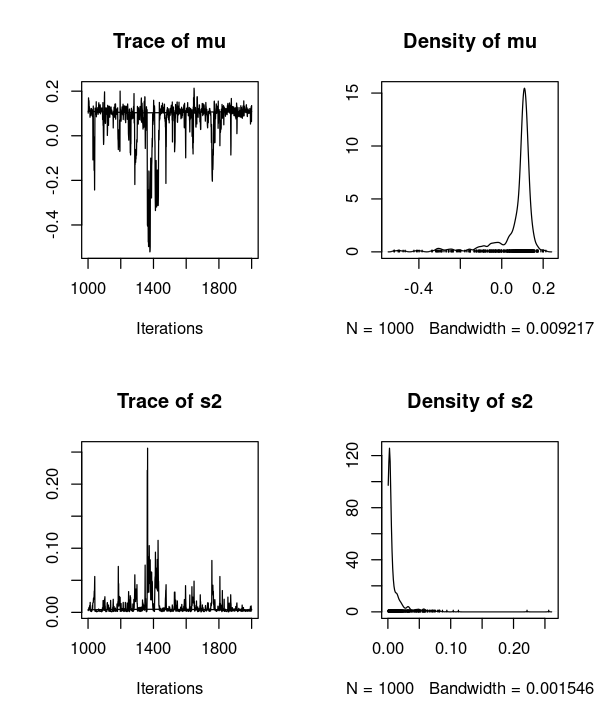

In [129]:
model2 <- "model{

 # Likelihood
 for(i in 1:n){
 Y[i] ~ dnorm(mu,tau) T(0,) ## truncates at 0
 }

 # Prior for mu
 mu ~ dnorm(mu0,tau0)

 # Prior for the precision
 tau ~ dgamma(a, b)

 # Compute the variance
 s2  <- 1/tau
}"

## hyperparams for tau
a <- 0.01
b <- 0.01

m2 <- jags.model(textConnection(model2), 
     n.chains = 1,
     data = list(Y=Y, n=n,
        mu0=mu0, tau0=1/s20, ## mu hyperparams
        a=a, b=b ## tau hyperparams
        ),
     inits=list(mu=3, tau=10) ## starting vals
    )

samp <- coda.samples(m2, 
  variable.names=c("mu","s2"), 
  n.iter=1000, progress.bar="none")

plot(samp)

summary(samp)

Now we plot each with their priors:

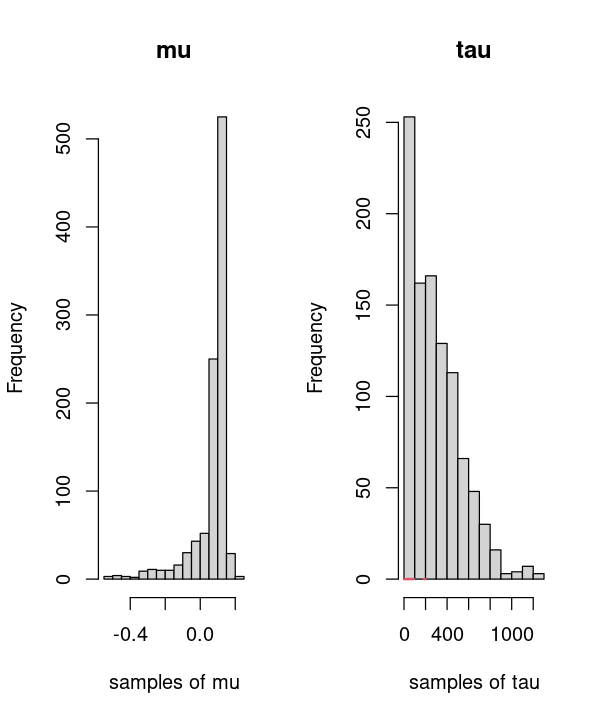

In [130]:
par(mfrow=c(1,2), bty="n")

hist(samp[[1]][,1], xlab="samples of mu", main="mu")
lines(x, dnorm(x, mean=mu0, sd=sqrt(s20)), 
  col=2, lty=2, lwd=2) ## prior

x2 <- seq(0, 200, length=1000)
hist(1/samp[[1]][,2], xlab="samples of tau", main="tau")
lines(x2, dgamma(x2, shape = a, rate = b), 
  col=2, lty=2, lwd=2) ## prior

We also want to look at the joint distribution of $\mu$ and $\sigma^2$:

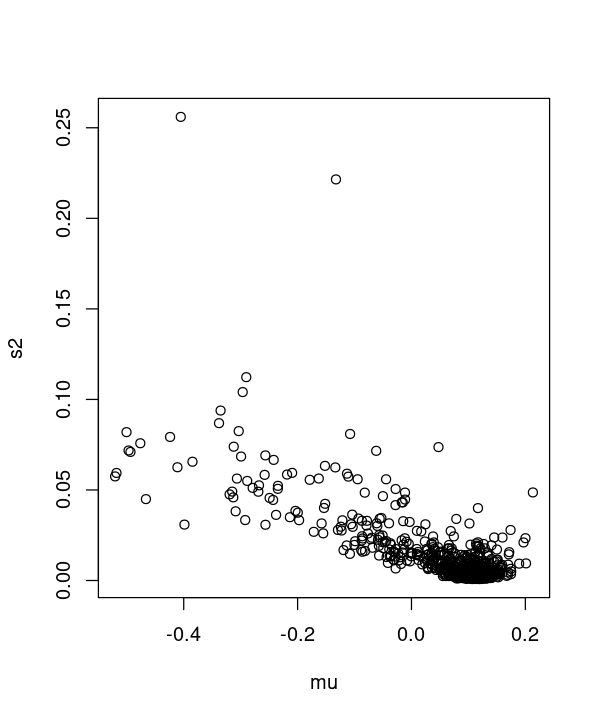

In [131]:
plot(as.numeric(samp[[1]][,1]), samp[[1]][,2], xlab="mu", ylab="s2")

### Exercise: Updating the Bayesian model

Redo the previous analysis placing a gamma prior on $\mu$ as well. Set the prior so that the mean and variance are the same as in the normal example from above (use moment matching). Do you get something similar?

## Aedes data revisited using Bayesian fitting

Now let's do some Bayesian model fitting to * Aedes * thermal performance data. Lets try out the `R2jags` package for this.

In [47]:
require(R2jags) # fitting
require(coda) # diagnostic plots
set.seed(1234)

Loading required package: R2jags

Loading required package: rjags

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot




Load the data:

In [48]:
Aaeg.data <- read.csv("../data/AeaegyptiTraitData.csv")

### The Data

These data are traits from * Aedes aegypti * mosquitoes measured across temperature in lab experiments. The traits we have data on thermal performance are:
- pEA: proportion surviving from egg to adulthood 
- MDR: mosquito development rate 
- PDR: parasite development rate (= 1/EIP the extrinsic incubation period) 
- $\mu$ (mu): death rate (= 1/longevity) 

Note that some of the traits come in multiple forms (e.g., $\mu$ and 1/$\mu$, PDR and EIP).

Have a look at the data:

In [49]:
head(Aaeg.data)

,trait.name,T,trait,ref,trait2,trait2.name
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,pEA,22,0.90812,Westbrook_Thesis_2010,NA,NA
2,pEA,27,0.93590,Westbrook_Thesis_2010,NA,NA
3,pEA,32,0.81944,Westbrook_Thesis_2010,NA,NA
4,MDR,22,0.09174,Westbrook_Thesis_2010,NA,NA
5,MDR,27,0.13587,Westbrook_Thesis_2010,NA,NA
6,MDR,32,0.15823,Westbrook_Thesis_2010,NA,NA


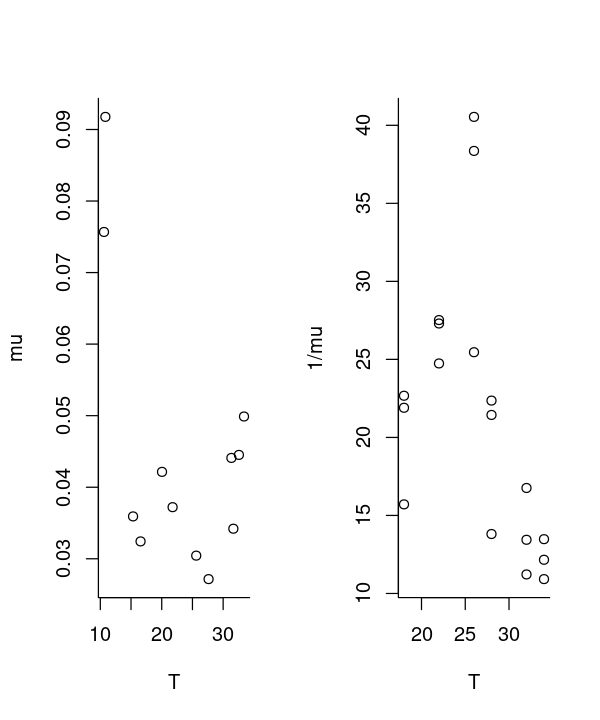

In [50]:
mu.data <- subset(Aaeg.data, trait.name == "mu")
lf.data <- subset(Aaeg.data, trait.name == "1/mu")
par(mfrow=c(1,2), bty="l") 
plot(trait ~ T, data = mu.data, ylab="mu")
plot(trait ~ T, data = lf.data, ylab="1/mu")

Note that the $\mu$ data is u-shaped and the lifespan data is unimodal (hump-shaped). 

Since thermal biology theory is based on unimodal thermal responses, we want to fit the trait as lifespan instead of $\mu$. Thus, we'll need to convert the $\mu$ data to lifespan by taking the inverse. The combined data should have a nice unimodal shape that we can fit a function to:

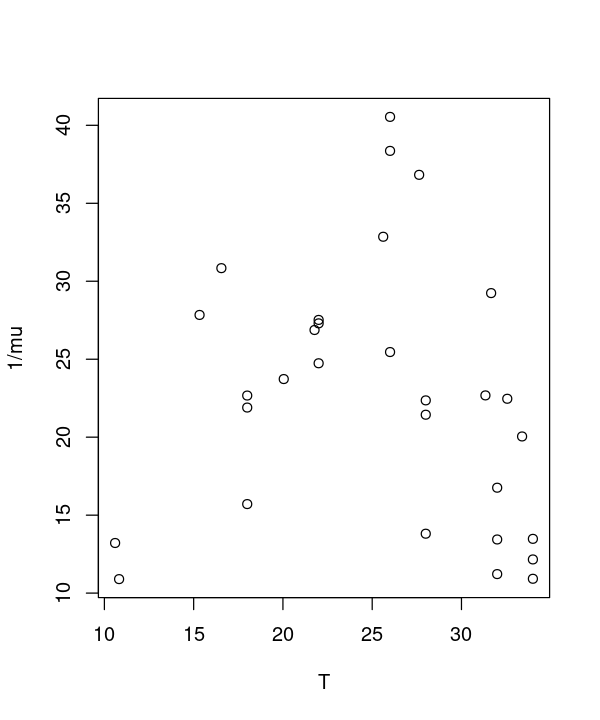

In [51]:
mu.data.inv <- mu.data # make a copy of the mu data
mu.data.inv$trait <- 1/mu.data$trait # take the inverse of the trait values to convert mu to lifespan
lf.data.comb <- rbind(mu.data.inv, lf.data) # combine both lifespan data sets together 
 
plot(trait ~ T, data = lf.data.comb, ylab="1/mu")

### Two thermal performance curve models
Most thermal response curves can be reasonably fit using one of two thermal reponses. Traits that respond unimodally but symmetrically to temperature can be fit with a quadratic function:

$ B = q (T-T_0) (T-T_m)$ 

Traits that respond unimodally but asymmetrically can be fitted with a Briere function (see definition [here](Miniproj-TPCs-Models)).

In both models, $T_0$ is the lower thermal limit, $T_m$ is the upper thermal limit (i.e., where the trait value goes to zero on either end), and $q$ scales the elevation of the curve, (and so also the value at the optimum temperature). 

### The thermal response model file
Unlike the previous bayesian \example, here we will provide jags with the model written as a `.txt` file. THis can be in your working directory, or elsewhere (but then inout the full path to it --- ideally a relative path). 

You can either write the text yourself directly to the file, or create it using the sink() function via your R script (see below):

In [52]:
sink("quad.txt") # create a file
cat("
 model{
 
 ## Priors
 cf.q ~ dunif(0, 1)
 cf.T0 ~ dunif(0, 24)
 cf.Tm ~ dunif(25, 45)
 cf.sigma ~ dunif(0, 1000)
 cf.tau <- 1 / (cf.sigma * cf.sigma)
 
 ## Likelihood
 for(i in 1:N.obs){
 trait.mu[i] <- -1 * cf.q * (temp[i] - cf.T0) * (temp[i] - cf.Tm) * (cf.Tm > temp[i]) * (cf.T0 < temp[i])
 trait[i] ~ dnorm(trait.mu[i], cf.tau)
 }
 
 ## Derived Quantities and Predictions
 for(i in 1:N.Temp.xs){
 z.trait.mu.pred[i] <- -1 * cf.q * (Temp.xs[i] - cf.T0) * (Temp.xs[i] - cf.Tm) * (cf.Tm > Temp.xs[i]) * (cf.T0 < Temp.xs[i])
 }
 } # close model
",fill=T)
sink()


 model{
 
 ## Priors
 cf.q ~ dunif(0, 1)
 cf.T0 ~ dunif(0, 24)
 cf.Tm ~ dunif(25, 45)
 cf.sigma ~ dunif(0, 1000)
 cf.tau <- 1 / (cf.sigma * cf.sigma)
 
 ## Likelihood
 for(i in 1:N.obs){
 trait.mu[i] <- -1 * cf.q * (temp[i] - cf.T0) * (temp[i] - cf.Tm) * (cf.Tm > temp[i]) * (cf.T0 < temp[i])
 trait[i] ~ dnorm(trait.mu[i], cf.tau)
 }
 
 ## Derived Quantities and Predictions
 for(i in 1:N.Temp.xs){
 z.trait.mu.pred[i] <- -1 * cf.q * (Temp.xs[i] - cf.T0) * (Temp.xs[i] - cf.Tm) * (cf.Tm > Temp.xs[i]) * (cf.T0 < Temp.xs[i])
 }
 } # close model



Note that the model file `quad.txt` has two mandatory sections (the priors and the likelihood) and one optional section (derived measures calculated from your fitted parameters).

In the example below for a quadratic function, most of the priors are specified via uniform distributions (the two arguments specific the lower and upper bounds, respectively). Note that unlike in R and most other programs, in jags, the inverse of the variance of the normal distribution is used, denoted by $\tau (= \frac{1}{\sigma^2}$). 

The likelihood for can be interpreted as follows: the observed data are normally distributed where the mean at a given temperature follows the quadratic equation.

Now, prepare the data for jags: 

In [53]:
# Parameters to Estimate
parameters <- c("cf.q", "cf.T0", "cf.Tm","cf.sigma", "z.trait.mu.pred")

# Initial values for the parameters
inits <- function(){list(
 cf.q = 0.01,
 cf.Tm = 35,
 cf.T0 = 5,
 cf.sigma = rlnorm(1))}

# MCMC Settings: number of posterior dist elements = [(ni - nb) / nt ] * nc
ni <- 25000 # number of iterations in each chain
nb <- 5000 # number of 'burn in' iterations to discard
nt <- 8 # thinning rate - jags saves every nt iterations in each chain
nc <- 3 # number of chains

# Temperature sequence for derived quantity calculations
Temp.xs <- seq(0, 45, 0.2)
N.Temp.xs <- length(Temp.xs)

### Fitting the trait thermal response; Pull out data columns as vectors
data <- lf.data.comb # this lets us reuse the same generic code: we only change this first line
trait <- data$trait
N.obs <- length(trait)
temp <- data$T

# Bundle all data in a list for JAGS
jag.data <- list(trait = trait, N.obs = N.obs, temp = temp, Temp.xs = Temp.xs, N.Temp.xs = N.Temp.xs)

Now run the fitting using jags:

In [54]:
lf.fit <- jags(data=jag.data, inits=inits, parameters.to.save=parameters, 
    model.file="quad.txt", n.thin=nt, n.chains=nc, n.burnin=nb, 
    n.iter=ni, DIC=T, working.directory=getwd())

module glm loaded

Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "trait" in data”
Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "N.obs" in data”
Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "temp" in data”
Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "Temp.xs" in data”
Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "N.Temp.xs" in data”


Compiling model graph



ERROR: Error in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, : Nothing to compile




Change into "mcmc" type samples for visualization with the `coda` package:

In [139]:
lf.fit.mcmc <- as.mcmc(lf.fit)

ERROR: Error in as.mcmc(lf.fit): object 'lf.fit' not found


### Running diagnostics

View the parameters (only the first 5 lines, or it will also show you all of your derived quantities):

In [140]:
lf.fit$BUGSoutput$summary[1:5,]

ERROR: Error in eval(expr, envir, enclos): object 'lf.fit' not found


Plot the chains:

In [141]:
plot(lf.fit.mcmc[,c(1,3,4)])

ERROR: Error in plot(lf.fit.mcmc[, c(1, 3, 4)]): object 'lf.fit.mcmc' not found


### Plot the fits

ERROR: Error in eval(predvars, data, env): object 'lf.fit' not found


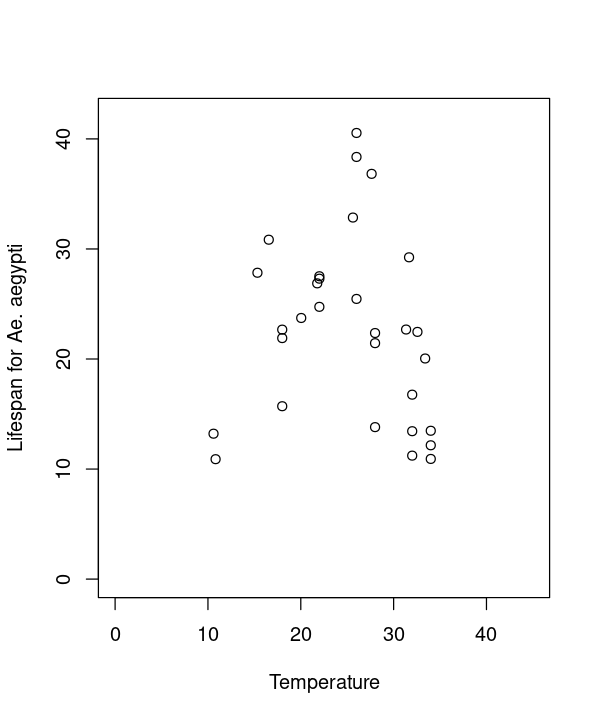

In [142]:
plot(trait ~ T, xlim = c(0, 45), ylim = c(0,42), data = lf.data.comb, ylab = "Lifespan for Ae. aegypti", xlab = "Temperature")
lines(lf.fit$BUGSoutput$summary[6:(6 + N.Temp.xs - 1), "2.5%"] ~ Temp.xs, lty = 2)
lines(lf.fit$BUGSoutput$summary[6:(6 + N.Temp.xs - 1), "97.5%"] ~ Temp.xs, lty = 2)
lines(lf.fit$BUGSoutput$summary[6:(6 + N.Temp.xs - 1), "mean"] ~ Temp.xs)

### Additional analyses

You can use the `which.max()` function to find the optimal temperature for adult lifespan:

In [143]:
Temp.xs[which.max(as.vector(lf.fit$BUGSoutput$summary[6:(6 + N.Temp.xs - 1), "mean"]))]

ERROR: Error in as.vector(lf.fit$BUGSoutput$summary[6:(6 + N.Temp.xs - 1), "mean"]): object 'lf.fit' not found


You can also pull out the lifespan values for each iteration of the MCMC chain over the temperature gradient to calculate $R_0$:

In [144]:
lf.grad <- lf.fit$BUGSoutput$sims.list$z.trait.mu.pred
dim(lf.grad) # A matrix with 7500 iterations of the MCMC chains at 226 temperatures

ERROR: Error in eval(expr, envir, enclos): object 'lf.fit' not found


## Fitting of abundance data

We will now perform a bayesian analysis of population growth data. 

In [1]:
require(R2jags) # does the fitting
require(coda) # makes diagnostic plots
library(IDPmisc) # makes nice colored pairs plots to look at joint posteriors

Loading required package: R2jags

Loading required package: rjags

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot




### The Data

These data are observations of the amphibian fungal pathogen _Batrachochytrium dendrobatidis_ being grown in liquid culture at multiple different temperatures. The experiment is conducted in 96 well plates with a fixed initial innoculation of fungal spores in each well, and the plate placed in a constant temperature incubator. Each day, 8 wells per plate are observed and the optical density (OD) is measured. We will focus on a single temperature trial across mulitple plates with OD as the response. 

We will fit a logistic model to these growth data. 

Let's have a look at the data first:

In [2]:
dat <- read.csv("../data/lb_ab_temps.csv")
head(dat)

,X,EXP,TEMP,DAY,ISOLATE,PLATE,WELL,OD,NC_AVG,OD_SUB
,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,2,5,1,LB_AB,P.16,1,0.120,0.1195,0.0005
2,2,2,5,1,LB_AB,P.16,2,0.120,0.1195,0.0005
3,3,2,5,1,LB_AB,P.16,3,0.122,0.1195,0.0025
4,4,2,5,1,LB_AB,P.16,4,0.123,0.1195,0.0035
5,5,2,5,1,LB_AB,P.16,5,0.125,0.1195,0.0055
6,6,2,5,1,LB_AB,P.16,6,0.125,0.1195,0.0055


We are only interested in a subset of these data, so we will subset out only those from experiment 2, and a temperature of 12$^\circ$C.

In [177]:
d2 <- dat[which(dat$EXP==2),2:8]
d2 <- d2[which(d2$TEMP==12),]
summary(d2)

      EXP         TEMP         DAY          ISOLATE             PLATE          
 Min.   :2   Min.   :12   Min.   : 1.00   Length:730         Length:730        
 1st Qu.:2   1st Qu.:12   1st Qu.: 9.00   Class :character   Class :character  
 Median :2   Median :12   Median :19.00   Mode  :character   Mode  :character  
 Mean   :2   Mean   :12   Mean   :19.04                                        
 3rd Qu.:2   3rd Qu.:12   3rd Qu.:29.00                                        
 Max.   :2   Max.   :12   Max.   :39.00                                        
      WELL             OD        
 Min.   :1.000   Min.   :0.0930  
 1st Qu.:2.000   1st Qu.:0.1630  
 Median :4.000   Median :0.2580  
 Mean   :4.315   Mean   :0.2437  
 3rd Qu.:6.000   3rd Qu.:0.3170  
 Max.   :8.000   Max.   :0.4600  

Now plot it:

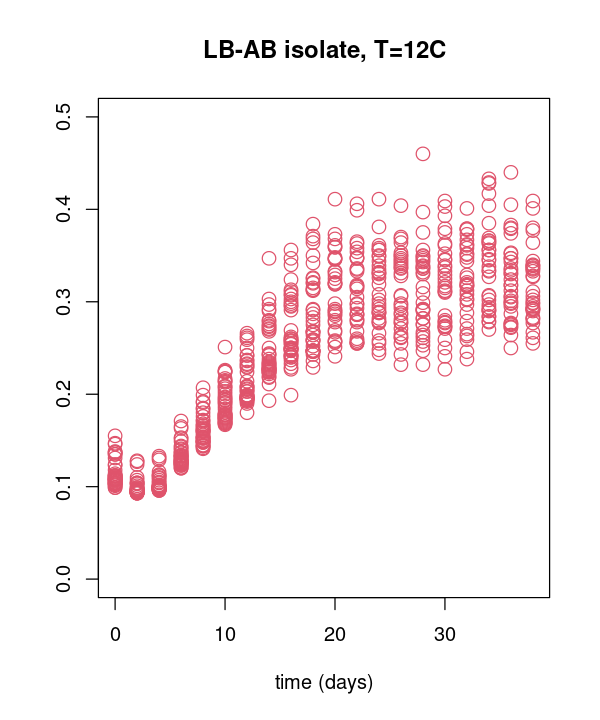

In [178]:
Temps <- seq(0,max(d2$DAY)-1, by=0.05)
mycol <- 1 
my.ylim <- c(0, 0.5)
my.title <- "LB-AB isolate, T=12C"

plot(d2$DAY-1, d2$OD, xlim=c(0,max(Temps)), ylim=my.ylim,
 pch=(mycol+20),
 xlab="time (days)", ylab="",
 main=my.title,
 col=mycol+1, cex=1.5)

### Specifying the growth curve

Although logistic growth is often written as a differential equation, here we will work with the analytic solution of the model:

$$
\mu(t) = \frac{KY_0}{Y_0+(K-Y_0)\exp{(-rt)}}
$$

This gives the mean function that we want to fit. We will assume log-normal noise around this response, as the optical density is bounded to be greater than 0 and since we also have increasing variance over time (as the optical density increases).


### The thermal response model file

JAGS needs the model written as a `.txt` or `.bug` file inside the working directory. You can either make the text file directly, or create it using the `sink()` function in your R script, as follows: 

In [201]:
sink("jags-logistic.bug")
cat("
 model {
 
 ## Likelihood
 for (i in 1:N) {
  Y[i] ~ dlnorm(log(mu[i]), tau)
  mu[i] <- K * Y0/(Y0+(K-Y0) * exp(-r * t[i]))
 }

 ## Priors
 r~dexp(1000)
 K ~ dunif(0.01, 0.6)
 Y0 ~ dunif(0.09, 0.15)
 tau <- 1/sigma^2
 sigma ~ dexp(0.1)

 } # close model
 ",fill=T)
sink()


  model {
    
    ## Likelihood
    for (i in 1:N) {
        Y[i] ~ dlnorm(log(mu[i]), tau)
        mu[i] <- K*Y0/(Y0+(K-Y0)*exp(-r*t[i]))
    }

    ## Priors
    r~dexp(1000)
    K ~ dunif(0.01, 0.6)
    Y0 ~ dunif(0.09, 0.15)
    tau<-1/sigma^2
    sigma ~ dexp(0.1)

  } # close model
    


Note that the model file has two mandatory sections (the priors and the likelihood) and one optional section (derived quantiaties calculated from your fitted parameters). 

In the example below we will build the model function with the log-normal likelihood for the logistic growth function. Priors are a combination of uniform and exponential distributions. As with the normal distribution, jags uses $\tau$ to parameterize the variance of the normal distribution ($\tau = 1/(\sigma^2)$). However it can be easier to specify the prior on sigma directly. In this example we will generate posterior samples of derived quantities outside of JAGS (so you can see what this is actually doing).


### Additional settings for jags 

Now for some additional settings/specifications for jags:

In [202]:
# Parameters to Estimate
parameters <- c('Y0', 'K', 'r', 'sigma')

# Initial values for the parameters
inits <- function(){list(
 Y0 = 0.1,
 K = 0.4,
 r = 0.1,
 sigma = rlnorm(1))}

# MCMC Settings: number of posterior dist elements = [(ni - nb) / nt ] * nc
ni <- 6000 # number of iterations in each chain
nb <- 1000 # number of 'burn in' iterations to discard
nt <- 1 # thinning rate - jags saves every nt iterations in each chain
nc <- 5 # number of chains

### Fitting the model

Now we can run jags:

In [203]:
# Pull out data columns as vectors
data <- d2 # this lets us reuse the same generic code: we only change this first line
Y <- data$OD
N <- length(Y)
t <- data$DAY

# Bundle all data in a list for JAGS
jag.data <- list(Y = Y, N = N, t = t)

In [207]:
# Run JAGS
OD.12C <- jags(data=jag.data, inits=inits, parameters.to.save=parameters, 
    model.file="jags-logistic.bug", n.thin=nt, n.chains=nc, n.burnin=nb, 
    n.iter=ni, DIC=T, working.directory=getwd())

Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "Y" in data”
Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "N" in data”
Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "t" in data”


Compiling model graph



ERROR: Error in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, : Nothing to compile




Change into "mcmc" type samples for visualization with `coda`:

In [208]:
OD.12C.mcmc <- as.mcmc(OD.12C)

ERROR: Error in as.mcmc(OD.12C): object 'OD.12C' not found


### Diagnostics

As you did in the [Traits bayesian fitting example](#Aedes-data-revisited-using-Bayesian-fitting), there are a number of model diagnostics that we need to check. First we want to look at the chains and confirm that they look like "fuzzy caterpillars" -- no linear/non-linear patterns across the chains, low auto-correlation, etc.

First view the fitted parameters:

In [183]:
OD.12C$BUGSoutput$summary

ERROR: Error in eval(expr, envir, enclos): object 'OD.12C' not found


Plot the chains using the coda package:

In [184]:
plot(OD.12C.mcmc[,c(1,2,4)])

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'plot': object 'OD.12C.mcmc' not found


We can examine the ACF of the chains as well, similarly to a time series:

In [185]:
s1 <- as.data.frame(OD.12C.mcmc[[1]])
par(mfrow=c(2,2))
for(i in 2:5) acf(s1[,i], lag.max=20)

ERROR: Error in as.data.frame(OD.12C.mcmc[[1]]): object 'OD.12C.mcmc' not found


There is still a bit of autocorrelation, but it isn't too bad. The chain for $\sigma$ is mixing best. We could reduce the autocorrelation even further by thinning the chain (i.e., change the `nt` parameter to 5 or 10).

The last important diagnostic is to compare the prior and posterior distributions. Various packages in R have bespoke functions to do this. Here we use functions that we provide in the `mcmc_utils.R` file provided on the website.

In [186]:
source("../code/mcmc_utils.R")

Warning message in file(filename, "r", encoding = encoding):
“cannot open file '../code/mcmc_utils.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


We also can write a function to put the samples into a convenient format for visualizing, etc:

In [187]:
samps <- NULL
for(i in 1:nc){
 samps <- rbind(samps, as.data.frame(OD.12C.mcmc[[i]]))
}

samps <- samps[,c(5,2,3,4)]

ERROR: Error in as.data.frame(OD.12C.mcmc[[i]]): object 'OD.12C.mcmc' not found


And also, we can building a list to hold all the information about the priors for each parameter:

In [188]:
priors <- list()
priors$names <- c("Y0", "K", "r","sigma")
priors$fun <- c("uniform", "uniform", "exp","exp")
priors$hyper <- matrix(NA, ncol=4, nrow=3)
priors$hyper[,1] <- c(0.09, 0.15, NA)
priors$hyper[,2] <- c(0.01, 0.6, NA)
priors$hyper[,3] <- c(1000, NA, NA) 
priors$hyper[,4] <- c(0.1, NA, NA)

Now we can plot the histograms of the posterior samples together with the prior distributions:

In [189]:
plot.hists(samps, my.par=c(2,2), n.hists=4, priors=priors, mai=c(0.5, 0.5, 0.25, 0.2))

ERROR: Error in plot.hists(samps, my.par = c(2, 2), n.hists = 4, priors = priors, : could not find function "plot.hists"


The prior distribution here is very different from the posterior. These data are highly informative for the parameters of interest and are very unlikely to be influenced much by the prior distribution (although you can always change the priors to check this). However, notice that $Y_0$ (the initial condition) is truncated by the prior. This is a fairly strong prior, because we know something about the initial optical density that is typical for the esperimental set up with the density of innoculum used and with a properly calibrated set-up.

### Visualizing the joint posterior of parameters 

It's often useful to also look at the joint distbution of all of your parameters together. Of course, if you have a high dimensional posterior, rendering a 2-D representation can be difficult. Instead, the standard is to examine the pair-wise posterior distribution, for instance as follows (using the `s1` data frame we created above):

In [197]:
ipairs(s1[,2:5], ztransf = function(x){x[x<1] <- 1; log2(x)})

ERROR: Error in is.data.frame(x): object 's1' not found


As you can see, estimates of $r$ and $K$ are highly correlated -- not surprising given the interplay between them in the logistic growth function. This correlation is an important feature of the system, and we use the full posterior distribution that includes this correlation when we want to build the corresponding posterior distribution of the behavior of the logistic function.

### The posterior distribution of the mean function

The final step is to check how well we are fitting the data. To do this we usually examine the posterior distribution of the mean function of our system, in this case the distribution of the logistic solution and compare this to the data. To do this, for each of our posterior samples (or a thinned subset), we plug the parameters for the $i^{\mathrm th}$ sample $\theta_i$ into our function of interest, and evaluate the function as a desired set of $x$'s. For instance, for logistic growth, we'll evaluate 
$$
\mu(t) = \frac{K_iY_{0,i}}{Y_{0,i}+(K_i-Y_{0,i})\exp{(-r_it)}}
$$
for the $i^{\mathrm th}$ set of parameters for a sequence of times, $t$. This we obtain points describing the curve $\mu_i(t)$ for each set of parameters. Here is one way to do this:

In [196]:
my.logistic <- function(t, Y0, K, r){
 return(K * Y0/(Y0+(K-Y0) * exp(-r * t)))
}

ts <- seq(0, 40, length=100)
ss <- seq(1, dim(samps)[1], by=10)
my.curves <- matrix(NA, nrow=length(ss), ncol=length(ts))

for(i in 1:length(ss)){
 my.curves[i,] <- my.logistic(t=ts, Y0=samps$Y0[i], K=samps$K[i], r=samps$r[i])
}

ERROR: Error in seq.default(1, dim(samps)[1], by = 10): 'to' must be of length 1


We can now plot all of these curves:

In [192]:
plot(ts, my.curves[1,], col=1, type="l", ylim=c(0.09, 0.36), 
  ylab="predicted OD", xlab="time (days)")
for(i in 2:length(ss)) lines(ts, my.curves[i,], col=i)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'y' in selecting a method for function 'plot': object 'my.curves' not found


Then we can summarize this posterior using the `apply` function to find the mean and the (for simplicity) quantile based 95% CI:

In [193]:
m.log <- apply(my.curves, 2, mean)
l.log <- apply(my.curves, 2, quantile, probs=0.025)
u.log <- apply(my.curves, 2, quantile, probs=0.975)

ERROR: Error in apply(my.curves, 2, mean): object 'my.curves' not found


For comparison, here is how to find the 95% HPD Interval across time, using the `HPDinterval` function from the `coda` package:

In [194]:
hpd.log <- NULL
for(i in 1:length(ts)){
 hpd.log <- cbind(hpd.log, as.numeric(HPDinterval(mcmc(my.curves[,i]))))
}

ERROR: Error in mcmc(my.curves[, i]): object 'my.curves' not found


And plot these together with the data (in this case the HPD and quantile based intervals are indistinguishable):

ERROR: Error in xy.coords(x, y): object 'm.log' not found


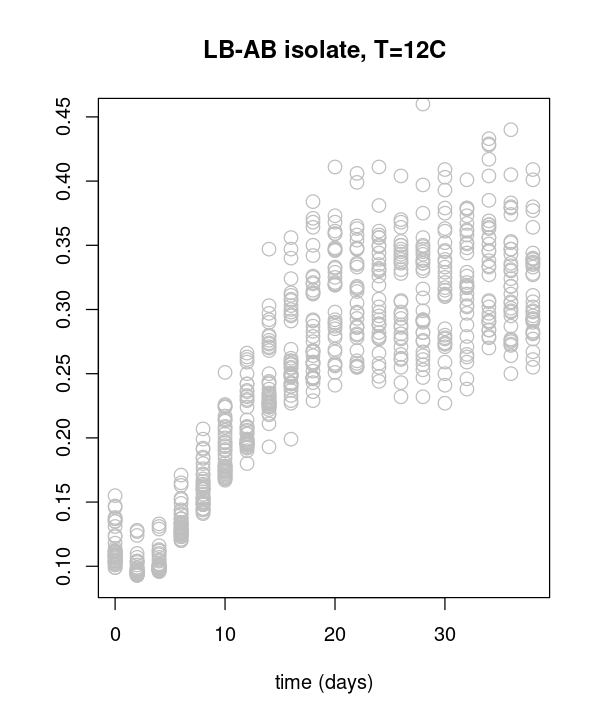

In [195]:
my.ylim <- c(0.09, 0.45)
my.title <- "LB-AB isolate, T=12C"

plot(d2$DAY-1, d2$OD, xlim=c(0,max(Temps)), ylim=my.ylim,
 pch=(mycol+20),
 xlab="time (days)", ylab="",
 main=my.title,
 col="grey", cex=1.5)
lines(ts, m.log, col=1, lwd=2)
lines(ts, l.log, col=2, lwd=2, lty=2)
lines(ts, u.log, col=2, lwd=2, lty=2)

lines(ts, hpd.log[1,], col=3, lwd=2, lty=3)
lines(ts, hpd.log[2,], col=3, lwd=2, lty=3)

Note that this only shows the uncertainty in the * mean function * -- the assumed model with log normal noise says that the observations simply have this mean. The fit is attributing the majority of the observed noise to process error rather than parameter uncertainty.

## Readings and Resources <a id='Readings'></a>

* Bolker, B. Ecological models and data in R. (Princeton University Press, 2008). 

* https://cran.r-project.org/web/packages/bayestestR/vignettes/bayestestR.html